## Predicting Taxi Ride Duration

In this project, we get data from January 2016 NYC yellow taxi rides and use a regression model to predict the duration of those taxi rides. We use the data from the NYC Taxi and Limosine Commission, found at this link: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

The specific data we sample from is found at this link: https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv. The file 'taxi.db' is a SQLite table (relation) containing 9 columns (attributes) and 100,000 rows (datapoints), a random sample from the csv above. Specifically, the columns of the taxi table are the following:

- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `passengers`: number of passengers in the vehicle (driver-entered value)
- `pickup_lon`: longitude where the meter was engaged
- `pickup_lat`: latitude where the meter was engaged
- `dropoff_lon`: longitude where the meter was disengaged
- `dropoff_lat`: latitude where the meter was disengaged
- `distance`: elapsed trip distance in miles reported by the taximeter
- `duration`: duration of the trip in seconds

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sqlite3

In [3]:
conn = sqlite3.connect('taxi.db')

In [4]:
query = 'SELECT * FROM taxi'
taxi = pd.read_sql(query, conn)
taxi.head(10)

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812
6,2016-01-28 15:39:31,2016-01-29 15:33:00,-73.964432,40.770443,-73.961655,40.774113,1,0.29,86009
7,2016-01-04 17:03:28,2016-01-04 17:32:04,-73.971367,40.797852,-73.922813,40.746685,2,6.30,1716
8,2016-01-17 19:21:16,2016-01-17 19:28:24,-73.978401,40.764992,-73.981018,40.762100,1,0.95,428
9,2016-01-14 17:54:32,2016-01-14 18:31:14,-73.976173,40.744934,-73.985298,40.714516,1,4.34,2202


## Data Cleaning and Exploratory Analysis

Since we are given dropoff and pickup coordinates, let's visualize the taxi rides geographically. The function `pickup_scatter` will make a scatterplot the taxi pickup longitudes ($x$-axis) and latitudes ($y$-axis).

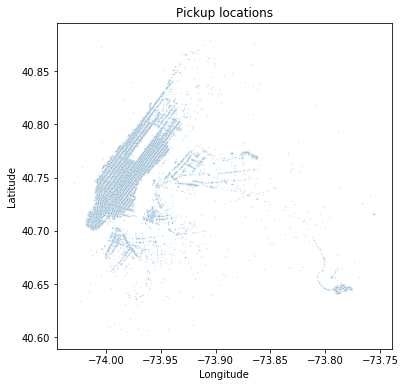

In [70]:
def pickup_scatter(t, alpha=0.2):
    sns.scatterplot(t['pickup_lon'], t['pickup_lat'], s=2, alpha=alpha)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(6,6))
pickup_scatter(taxi)

As we can see above, there seems to be an outlier at the origin that doesn't seem right for our purposes of dealing with Manhattan taxi rides. This leads to a bad, very zoomed-out plot of the pickup locations. Let's select only those taxi rides that are located within the boundaries of New York City, which are:

 - Longitude: [-74.03, -73.75]
 - Latitude: [40.6, 40.88]
 
In particular, we select all taxi rides where both the pickup and dropoff locations are located within these boundaries.

(97692, 9)

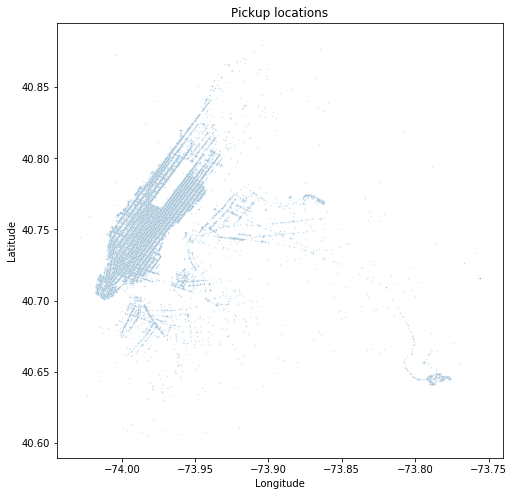

In [6]:
lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]

def cons_bound_str(field, bounds):
    """Helper function that constructs the string used for the query in selecting datapoints
       where the given field is within the given boundaries"""
    return field + " >= " + str(bounds[0]) + " AND " + field + " <= " + str(bounds[1])

pickup_bound_lon = cons_bound_str("pickup_lon", lon_bounds)
pickup_bound_lat = cons_bound_str("pickup_lat", lat_bounds)
dropoff_bound_lon = cons_bound_str("dropoff_lon", lon_bounds)
dropoff_bound_lat = cons_bound_str("dropoff_lat", lat_bounds)

query = "SELECT * FROM taxi WHERE " + pickup_bound_lon + " AND " \
        + pickup_bound_lat + " AND " + dropoff_bound_lon + " AND " + dropoff_bound_lat

taxi = pd.read_sql(query, conn)
plt.figure(figsize=(8,8))
pickup_scatter(taxi)
taxi.shape

We can already see an outline of the streets of Manhattan, along with other points outside the island. Indeed, comparing to a map of New York, we see that there are concentrations of pickups located at the two airports: LaGuardia and JFK. For our purposes, let's look only at taxi rides that start and end within Manhattan island. The csv-file `manhattan.csv` lists the vertices (as longitude, latitude pairs) of the polygon that approximates the boundaries of Manhattan island. We will put the resulting taxi rides into a new dataframe called `manhattan_taxi`.

The function below, `in_manhattan`, is implemented based on the information on [Point-In-Polygon Algorithm — Determining Whether A Point Is Inside A Complex Polygon](http://alienryderflex.com/polygon/). Note: this will take some time.

In [7]:
polygon = pd.read_csv('manhattan.csv')

def in_manhattan(x, y):
    """Checks whether the given point (x,y) is in Manhattan."""
    num_corners = len(polygon)
    poly_x = polygon['lon']
    poly_y = polygon['lat']
    j = num_corners - 1
    odd_nodes = False
    for i in range(num_corners):
        if (poly_y[i] < y and poly_y[j] >= y) or (poly_y[j] < y and poly_y[i] >= y):
            if poly_x[i]+(y-poly_y[i])/(poly_y[j]-poly_y[i])*(poly_x[j]-poly_x[i]) < x:
                odd_nodes = not odd_nodes
        j = i
    return odd_nodes
    
# Recommended: Then, apply this function to every trip to filter clean_taxi.
pickup_in_manhattan = np.array([in_manhattan(x, y) for x,y in taxi[['pickup_lon', 'pickup_lat']].values])
dropoff_in_manhattan = np.array([in_manhattan(x, y) for x,y in taxi[['dropoff_lon', 'dropoff_lat']].values])
manhattan_taxi = taxi[pickup_in_manhattan & dropoff_in_manhattan]
display(manhattan_taxi.head(10))
manhattan_taxi.shape

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812
6,2016-01-28 15:39:31,2016-01-29 15:33:00,-73.964432,40.770443,-73.961655,40.774113,1,0.29,86009
8,2016-01-17 19:21:16,2016-01-17 19:28:24,-73.978401,40.764992,-73.981018,40.762100,1,0.95,428
9,2016-01-14 17:54:32,2016-01-14 18:31:14,-73.976173,40.744934,-73.985298,40.714516,1,4.34,2202
10,2016-01-05 12:19:17,2016-01-05 12:30:54,-73.956406,40.768028,-73.978561,40.783222,3,2.07,697
11,2016-01-31 12:07:41,2016-01-31 12:24:53,-74.000114,40.760590,-73.972900,40.748585,1,1.80,1032


(83402, 9)

Finally, let's do some cleaning of the data: in particular, let's only include trips with a positive passenger count, a positive distance, a duration of at least 1 minute and at most 1 hour, and an average speed of at most 100 miles per hour.

In [8]:
manhattan_taxi = manhattan_taxi.query("passengers > 0 and distance > 0 and duration >= 60 and \
                                            duration <= 60*60 and distance / duration <= 100/3600")
manhattan_taxi.shape

(82800, 9)

Now that we are done with cleaning our data, let's begin our exploratory data analysis. To summarize our data pre-processing, of the original 100,000 trips in the original dataset, we first filtered out the trips that either picked up or dropped off outside the boundaries of New York City. This resulted in dataframe consisting of 97,692 trips. We did even further filtering, resulting in 83,402 trips that were located inside Manhattan island. Finally, we cleaned out 602 anamolous trips, resulting in a dataframe of 82,800 rows.

We wish to develop a general model that could potentially be used for future taxi rides. Of course, unseen future distributions may be different from the distributions in our obtained training data. However, a reasonable assumption is to use typical examples in our training data, as these will best represent future observations, on average.

Let us first make a plot of the total number of taxi rides _by date_. To do this, we will modify the dataframe we have and add a new column that consists of just the date of the pickups of the taxi rides (as opposed to the exact date & time). We see that the datetime columns are actually strings, so we convert to a datetime object in the `date` column.

In [10]:
import datetime

manhattan_taxi['date'] = manhattan_taxi['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x[:10], '%Y-%m-%d'))
manhattan_taxi.head(5)

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981,2016-01-30
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,2016-01-04
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,2016-01-07
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,2016-01-08
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812,2016-01-02


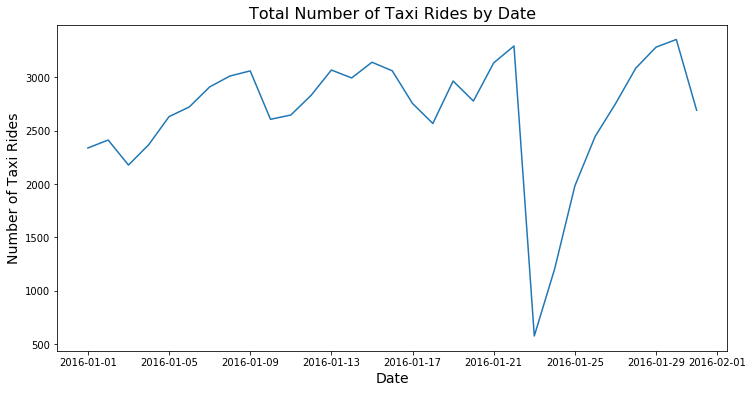

In [12]:
# Plot number of taxi rides by date
plt.figure(figsize=(12, 6))
plt.title("Total Number of Taxi Rides by Date", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Taxi Rides", fontsize=14)
sns.lineplot(data=manhattan_taxi.groupby('date').count()['duration']);

In terms of number of taxi rides, we observe some atypical days, such as New Years Day (January 1) falling on a Friday, MLK Jr. Day (January 18), and a substantial dip in rides on January 23. In fact, a google search reveals that there was an historic blizzard in NYC on the 23rd and 24th of January, 2016. As mentioned above, in order to use this dataset in our regression model, we should account for these phenomena. One simple way to account for this is to remove atypical days from the training data. We choose the first three days of the month, MLK Jr. Day, and the days of and following the blizzard.

In [13]:
import calendar
import re

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [datetime.date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

manhattan_taxi_final = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



## Feature Engineering

Let's do some additional exploratory analysis as part of feature engineering. First, we divide our data into a train and test set. Then, using our training set only, let's make a visualization of taxi ride duration by day and by hour. Then, let's visualize the number of passengers in taxi rides, and let's explore the distribution of average speed of taxi rides. In order for us to analyze taxi rides by hour and speed, we will add columns for those respective data.

In [96]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(manhattan_taxi_final, train_size=0.8, test_size=0.2)
print('Train-shape:', train.shape, 'Test-shape:', test.shape)

Train-shape: (53680, 10) Test-shape: (13421, 10)


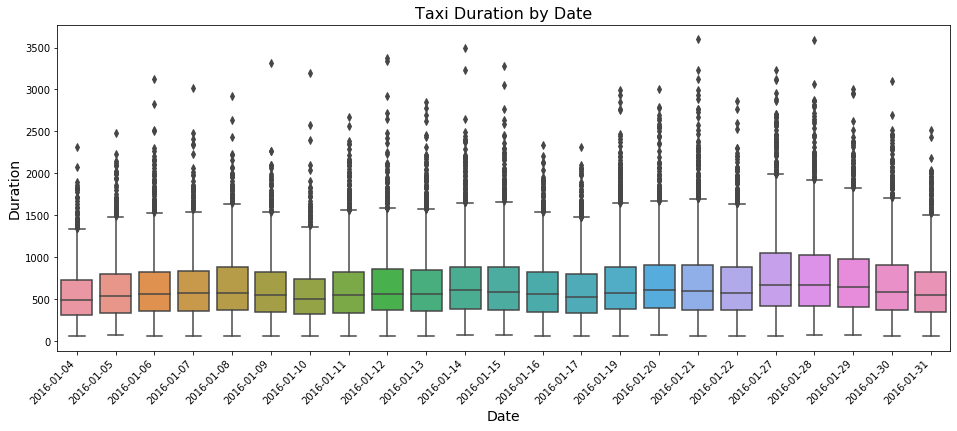

In [32]:
# We make a boxplot of taxi ride duration by date.

def duration_boxplot(df, col, title_string):
    """Make a boxplot of taxi duration with standardized formatting the x-axis labels in the plot"""
    fig, ax = plt.subplots(figsize=(16,6))
    plt.title("Taxi Duration by " + title_string, fontsize=16)
    sns.boxplot(data=df, x=col, y="duration", ax=ax)
    plt.xlabel(title_string, fontsize=14)
    plt.ylabel("Duration", fontsize=14)
    if type(col) == str and col == 'date':
        xlabel = df[col].dt.strftime('%Y-%m-%d').sort_values().unique()
        ax.set_xticklabels(labels=xlabel, rotation=45, ha='right');
    plt.show()
    
duration_boxplot(train, 'date', 'Date')

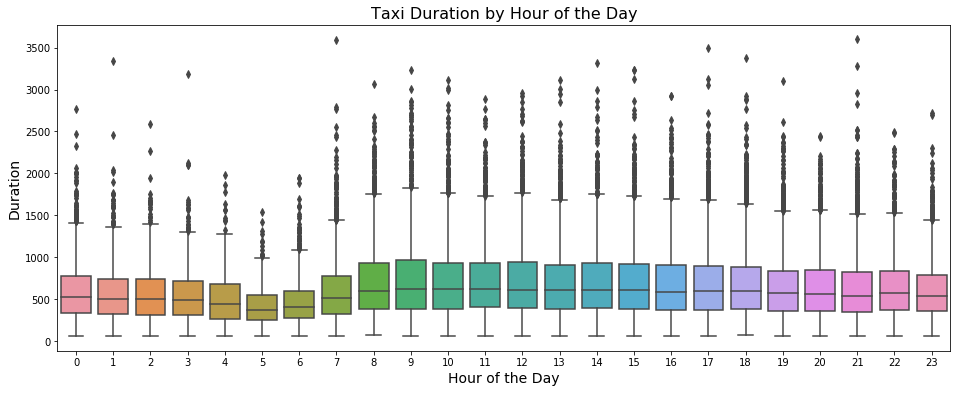

In [31]:
# Here we plot the duration by hour of the day
duration_boxplot(train, 'hour', 'Hour of the Day')

From the first plot above, it seems that during the weekdays, the durations of taxi trips are longer on average than the durations of taxi trips on weekends. In fact, in some weeks it looks like the durations increase slightly, then decrease as the week closes, with the the lowest duration happening on Sunday. We conclude that whether a day is a weekend or not seems important for predicting duration.

The second plot of duration by hour shows that on average, taxi rides are slightly shorter in duration in the early hours of the morning, i.e., 12am - 6am. From then (6am to midnight the next day), it seems that the distribution of taxi ride duration increases at hours 7 and 8. However, we do notice a slight decrease throughout the rest of the day, so we will divide the day into three periods as one of our features: early morning, daytime, and nighttime.

Below we augment our dataframe with the following columns:
 - `hour`: The hour (0 to 23) of the pickup time. For example, a pickup time of 4:20pm would have the hour as 16.
 - `time_of_day`: Early morning (12am-6am): 1,  Daytime (6am-6pm): 2,  Nighttime (6pm-12am): 3
 - `day`: Day of the week, Monday: 0, ... , Sunday:6
 - `weekend`: Mon-Fri: 0, Sat & Sun: 1
 - `speed`: Average speed in miles per hour of the taxi ride

In [19]:
def speed(df):
    """Takes in the dataframe in the original format and returns the average speed in mph"""
    return df['distance'] / df['duration'] * 60 * 60

def get_feature_matrix(df):
    X = df.copy()
    pickup_time = pd.to_datetime(df['pickup_datetime'])
    X.loc[:, 'hour'] = pickup_time.dt.hour
    X.loc[:, 'day'] = pickup_time.dt.weekday
    X.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    X.loc[:, 'time_of_day'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    X.loc[:, 'speed'] = speed(df)
    return X
    
train = get_feature_matrix(train)
test = get_feature_matrix(test)
train.head(5)

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date,hour,day,weekend,time_of_day,speed
22571,2016-01-13 07:52:40,2016-01-13 07:57:37,-73.983124,40.781754,-73.992546,40.768471,1,1.00,297,2016-01-13,7,2,0,2,12.121212
7069,2016-01-11 18:11:41,2016-01-11 18:18:03,-73.980560,40.728008,-73.989647,40.738392,4,1.15,382,2016-01-11,18,0,0,3,10.837696
32369,2016-01-19 16:45:39,2016-01-19 16:58:54,-73.991722,40.746777,-74.001190,40.756371,2,1.22,795,2016-01-19,16,1,0,2,5.524528
85914,2016-01-19 05:20:03,2016-01-19 05:21:30,-73.997437,40.743725,-73.993423,40.741962,1,0.20,87,2016-01-19,5,1,0,1,8.275862
32655,2016-01-05 08:33:48,2016-01-05 08:40:46,-73.990623,40.756317,-73.978470,40.757584,1,0.90,418,2016-01-05,8,1,0,2,7.751196


Let's take a look at the distribution of taxi ride speeds by period (early morning, daytime, nighttime) to see the effects of traffic depending on the time of day of the ride. As we can see from the histogram below, there are indeed differences in the distributions of speed by time of day. Daytime taxi rides tend to move slower on average than nighttime rides, followed by early morning taxi rides, which seem to move faster. This is reasonable and can be explained by rush hour traffic during the day and evening, and usually empty roads in the early morning.

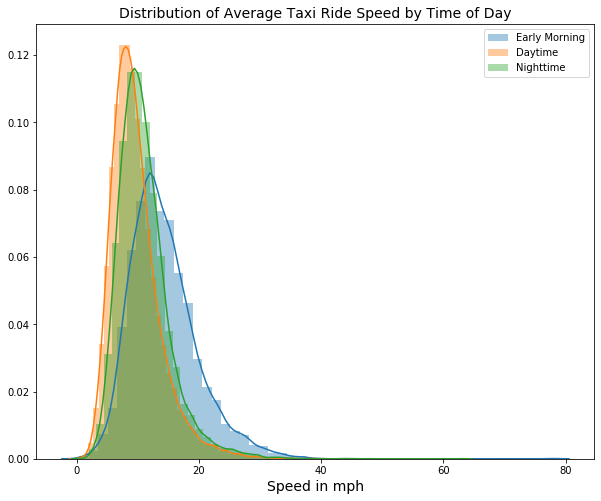

In [42]:
plt.figure(figsize=(10,8))
for i in [1,2,3]:
    sns.distplot(train[train['time_of_day'] == i]['speed'])
plt.legend(['Early Morning', 'Daytime', 'Nighttime'])
plt.xlabel("Speed in mph", fontsize=14)
plt.title("Distribution of Average Taxi Ride Speed by Time of Day", fontsize=14);

Let's also make a plot of average speed distribution depending on whether the ride took place on a weekday or weekend. As we can see, there is indeed a slight difference in speed: weekend  trips seems to go faster then weekday trips.

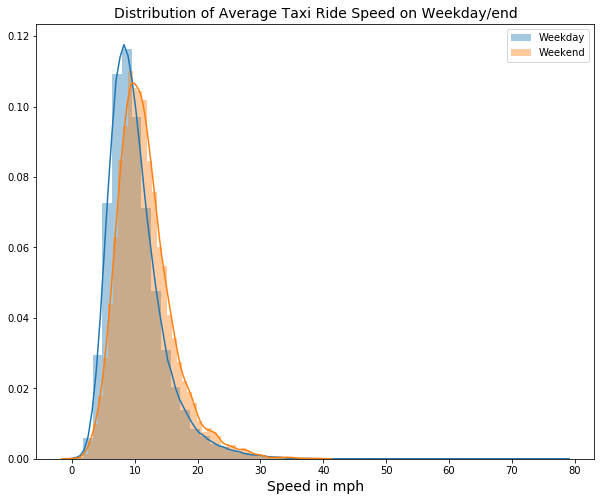

In [73]:
plt.figure(figsize=(10,8))
for i in [0,1]:
    sns.distplot(train[train['weekend'] == i]['speed'])
plt.legend(['Weekday', 'Weekend'])
plt.xlabel("Speed in mph", fontsize=14)
plt.title("Distribution of Average Taxi Ride Speed on Weekday/end", fontsize=14);

I've been to New York myself, and I personally have been in taxis (Ubers) around Manhattan. The island itself is often seen to be divided into three regions regions: lower Manhattan (Wall St. and downtown), mid-Manhattan (Times Square), and upper Manhattan (Central Park). Perhaps adding a feature based on the region of the pickup location would be helpful in our prediction. Let's take a look at our "map" of Manhattan:

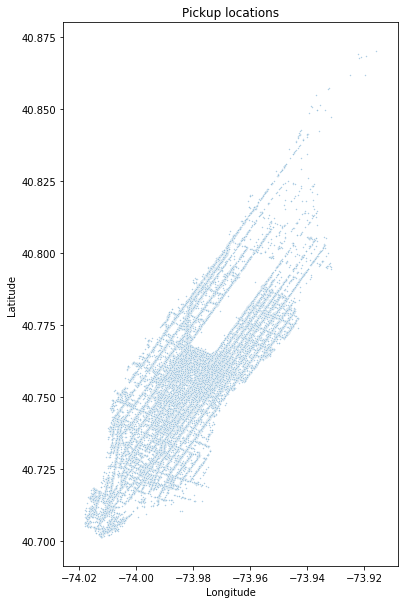

In [60]:
plt.figure(figsize=(6,10))
pickup_scatter(train, alpha=0.6)

These are all simply data points in two-dimensional space, and so the way we will divide Manhattan into lower, mid, and upper is via a principal components analysis. The first principal component axis will clearly line up with Manhattan island's "long side." Then, we notice that by simply dividing the data points into three equal bins based on the value of the first principal component, we get an accurate division.

In [46]:
# Find the first principal component
D = train[['pickup_lon', 'pickup_lat']]
pca_n = len(train)
pca_means = D.apply(np.mean, axis=0)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """This function will add a region column to t based on the first principal component"""
    D = t[['pickup_lon', 'pickup_lat']]
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = (D - pca_means) / np.sqrt(pca_n) 
    first_pc = (X @ vt.T)[0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)

Let's make a plot of the regions. This is sufficient for our purposes of feature engineering. Finally, let's make a histogram of average speed based on the region of the pickup location.

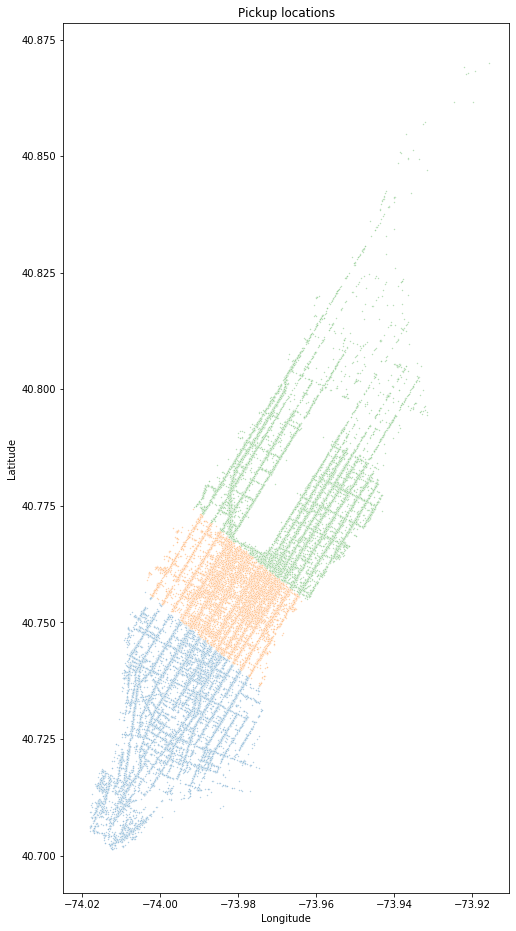

In [72]:
plt.figure(figsize=(8,16))
for i in [0,1,2]:
    region = train[train['region'] == i]
    pickup_scatter(region, alpha=0.5)

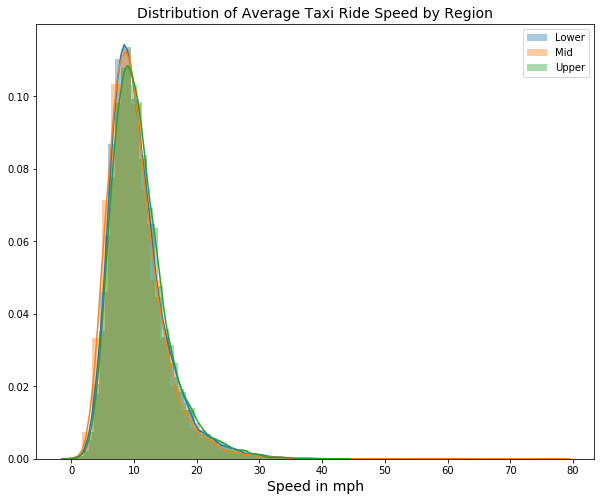

In [74]:
plt.figure(figsize=(10,8))
for i in [0,1,2]:
    sns.distplot(train[train['region'] == i]['speed'])
plt.legend(['Lower', 'Mid', 'Upper'])
plt.xlabel("Speed in mph", fontsize=14)
plt.title("Distribution of Average Taxi Ride Speed by Region", fontsize=14);

The plot above shows very little difference in the distribution of speed based on region. But let's take a look at this same plot only looking at early morning taxi rides, which does show a slight difference in speed distribution based on region. In particular, lower and mid-Manhattan early morning taxi rides move slower than those in upper Manhattan.

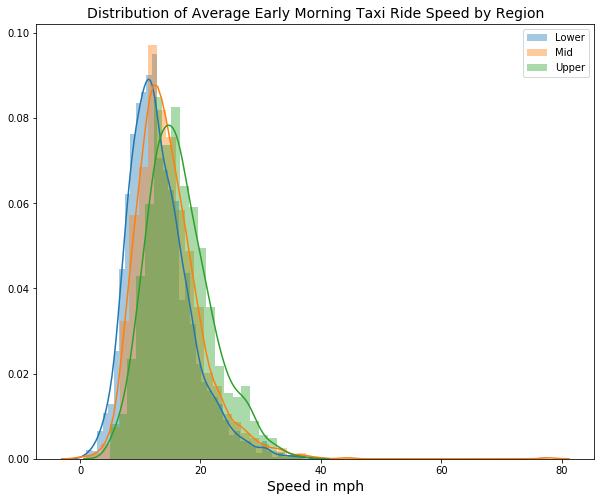

In [80]:
plt.figure(figsize=(10,8))
for i in [0,1,2]:
    sns.distplot(train[(train['time_of_day'] == 1) & (train['region'] == i)]['speed'])
plt.legend(['Lower', 'Mid', 'Upper'])
plt.xlabel("Speed in mph", fontsize=14)
plt.title("Distribution of Average Early Morning Taxi Ride Speed by Region", fontsize=14);

Finally, let's create our design matrix that we will use to predict taxi ride duration. Notice that the `weekend` and `time_of_day` variables are redundant because there are already `day` and `hour` variables. Furthermore, since we have to predict duration, we can't use the `speed` column. Below we write the function that takes in the originally formatted database of taxi rides and gives the appropriate design matrix for our prediction.

In [88]:
from sklearn.preprocessing import StandardScaler

numerical_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
categorical_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[numerical_vars])

def design_matrix(df):
    """This function takes in the taxi ride dataframe, the connection to the taxi ride SQLite database"""
    scaled = df[numerical_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    # Creates indicator variables for all categorical variables
    categoricals = [pd.get_dummies(df[s], prefix=s, drop_first=True) for s in categorical_vars]
    return pd.concat([scaled] + categoricals, axis=1)

In [90]:
design_matrix(train).head(10)

,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,distance,hour_1,hour_2,hour_3,hour_4,hour_5,...,hour_22,hour_23,day_1,day_2,day_3,day_4,day_5,day_6,region_1,region_2
22571,-0.115611,1.280214,-0.716129,0.515526,-0.610157,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
7069,0.043495,-1.250907,-0.548465,-0.743808,-0.504231,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32369,-0.649278,-0.367018,-1.216033,0.008917,-0.454800,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
85914,-1.003951,-0.510740,-0.766869,-0.594317,-1.175093,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
32655,-0.581090,0.082292,0.097925,0.059706,-0.680774,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
61832,-1.801848,-2.028802,-1.448557,-1.473216,-0.807885,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8884,-0.158228,0.261765,-1.010424,-1.405338,0.936355,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
61655,0.032130,-0.778961,0.124398,-1.524963,-0.186455,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
52625,-0.046475,0.999237,0.176904,1.315526,-0.659589,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
18706,1.588621,1.306084,0.374571,0.055394,0.096013,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Modeling and Predicting

Let's now begin our process of model selection and predicting taxi ride duration from the features we have explored and created above. First, let's use mean-square error (based on $l2$ loss) as the performance metric of our predictions. We will use the simplest model that simply predicts the avrerage duration of the taxi rides in our training set.

In [97]:
def rmse(errors):
    """Return the root mean square error."""
    return np.sqrt(np.mean(errors ** 2))

constant_model = np.mean(train['duration'])

constant_rmse = rmse(test['duration'] - constant_model)
print("Baseline RMSE:", constant_rmse)

Baseline RMSE: 403.14951611273636
